In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

sns.set()

df_wo_inf = pd.read_csv("csvs_final/all_data_final_no_inf.csv")
df_with_inf =  pd.read_csv("csvs_final/all_data_final_with_inf.csv")

baseline_fillup = pd.read_csv("csvs_final/baseline_fillup.csv")

## df for baseline
df_bsline_with_inf = df_with_inf[df_with_inf.hierarchy=='[1]']
df_bsline_wo_inf = df_wo_inf[df_wo_inf.hierarchy=='[1]']


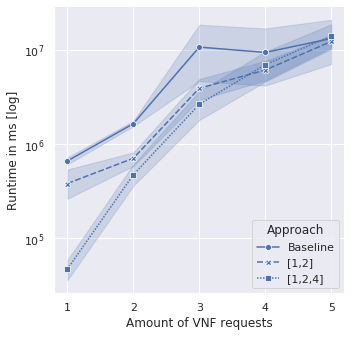

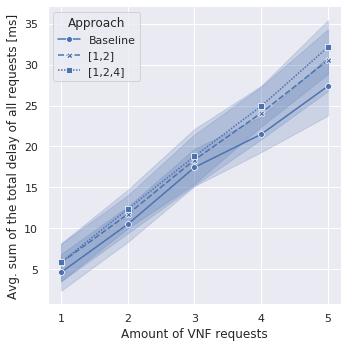

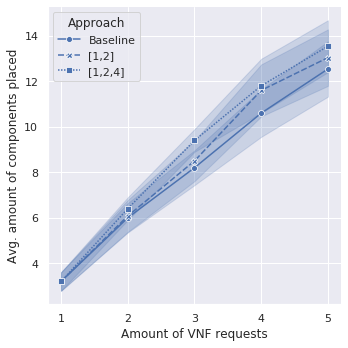

In [2]:
## runtime plots
sns_plot = sns.relplot(data=df_wo_inf, x="request_count", markers=True, y="runtime", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Runtime in ms [log]')
ax = sns_plot.axes[0][0]
ax.set_yscale("log")
plt.legend(title='Approach', loc='lower right', labels=['Baseline', '[1,2]', '[1,2,4]'])
sns_plot.savefig("final_figs/final_runtimes.pdf")


# sum tot delay makes only sense for the w/o inf df
sns_plot = sns.relplot(data=df_wo_inf, x="request_count", markers=True, ci="sd", y="sum_total_delay", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Avg. sum of the total delay of all requests [ms]')
plt.legend(title='Approach', loc='upper left', labels=['Baseline', '[1,2]', '[1,2,4]'])

sns_plot.savefig("final_figs/final_accumulated_tot_delay.pdf")

# placements makes only sense for the w/o inf df
sns_plot = sns.relplot(data=df_wo_inf, x="request_count", markers=True, ci='sd', y="placements", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Avg. amount of components placed')
plt.legend(title='Approach', loc='upper left', labels=['Baseline', '[1,2]', '[1,2,4]'])

sns_plot.savefig("final_figs/final_placements.pdf")

Need the following runs: set()


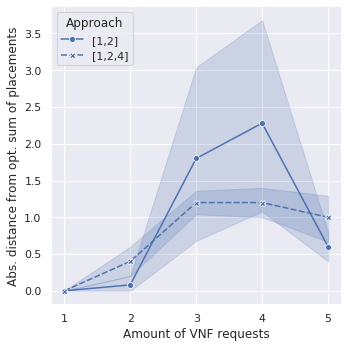

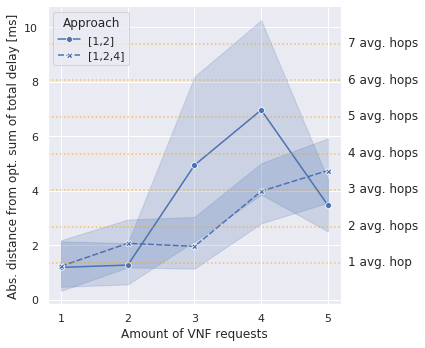

In [3]:
# WITH INFEASIBLES!

## Distances from optimal solution

# placements (cuz its easy)
distances = pd.DataFrame(columns=["hierarchy", "gurobi_seed", "vnf_requests_id","requests_count", "placements_distance", "total_delay_distance"])

needed_runs = set()

for (i, gurobi_seed, hierarchy_id, hierarchy, hierarchy_paths, graph_path, vnf_requests_id, ingr_egr, requests_count, vnf_requests_path, placements, runtime, avg_total_delay,avg_e2e_delay,sum_total_delay,sum_e2e_delay, method) in df_with_inf.itertuples():
  #  print("hierarchy: {}, gurobi_seed:{}, vnf_requests_id:{}, placements:{}, s_total_delay:{}".format(hierarchy, gurobi_seed, vnf_requests_id,placements, sum_total_delay))
    # now placement distance ->
    if hierarchy == '[1]':
        # no loss for baseline
        continue
    opt = df_bsline_with_inf[(df_bsline_with_inf.gurobi_seed == gurobi_seed) & (df_bsline_with_inf.vnf_requests_id == vnf_requests_id)]
    next_gurobi_seed = int(gurobi_seed)
    ctr = 0
    # if the run failed for the baseline check if there is another seed (they are all the same)
    while len(opt) == 0 and ctr < 5:
        next_gurobi_seed = int(next_gurobi_seed) + 1 % 5
        opt = df_bsline_with_inf[(df_bsline_with_inf.gurobi_seed == next_gurobi_seed) & (df_bsline_with_inf.vnf_requests_id == vnf_requests_id)]
        ctr += 1
    if len(opt) == 0:
        continue
    if placements == 'INFEASIBLE':
        distance = float(opt['placements'])
     #   continue
    else:
        distance = float(abs(float(placements)-float(opt['placements'])))
    if distance == 0:
        tot_delay_distance = abs(float(sum_total_delay) - float(opt['sum_total_delay']))
        distances = distances.append({'hierarchy': hierarchy, 'gurobi_seed':gurobi_seed, 'vnf_requests_id':vnf_requests_id, 'placements_distance':distance, 'total_delay_distance':float(tot_delay_distance), 'requests_count':requests_count}, ignore_index=True)
    else:
        if placements == 'INFEASIBLE':
            tot_delay_distance = float(opt['sum_total_delay'])
        else:
            bs_fillup = baseline_fillup.query("vnf_requests_id == {} & placements == {}".format(vnf_requests_id, placements))
            tot_delay_opt = bs_fillup['sum_total_delay']
            tot_delay_distance = abs(float(sum_total_delay) - float(tot_delay_opt))
            
        distances = distances.append({'hierarchy': hierarchy, 'gurobi_seed':gurobi_seed, 'vnf_requests_id':vnf_requests_id, 'placements_distance':distance, 'total_delay_distance':tot_delay_distance, 'requests_count':requests_count}, ignore_index=True)

       # print ("Seed:{}, vnf_requests_id:{} needs an opt run with placements set to {}".format(gurobi_seed, vnf_requests_id, placements))

sns_plot = sns.relplot(data=distances, x="requests_count", markers=True, y="placements_distance", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Abs. distance from opt. sum of placements')
plt.legend(title='Approach', loc='upper left', labels=['[1,2]', '[1,2,4]'])

sns_plot.savefig("final_figs/final_absolute_placements_w_inf.pdf")



sns_plot = sns.relplot(data=distances, x="requests_count",markers=True, y="total_delay_distance", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Abs. distance from opt. sum of total delay [ms]')
plt.legend(title='Approach', loc='upper left', labels=['[1,2]', '[1,2,4]'])
plt.xticks(np.arange(1,6,1))
ax1= sns_plot.axes[0][0]

avg_delay = 1.342150105084392
ax1.axhline(avg_delay, ls=':', color='orange', alpha=0.6)
ax1.text(5.3, avg_delay - .1, "1 avg. hop")
ax1.text(5.3, 2 * avg_delay - .1, "2 avg. hops")
ax1.text(5.3, 3* avg_delay - .1, "3 avg. hops")
ax1.text(5.3, 4*avg_delay -.1, "4 avg. hops")
ax1.text(5.3, 5*avg_delay-.1, "5 avg. hops")
ax1.text(5.3, 6*avg_delay-.1, "6 avg. hops")
ax1.text(5.3, 7*avg_delay-.1, "7 avg. hops")
ax1.axhline(2 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(3 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(4 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(5 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(6 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(7 * avg_delay, ls=':', color='orange', alpha=0.6)
sns_plot.savefig("final_figs/final_absolute_distance_tot_w_inf.pdf")



print("Need the following runs: {}".format(needed_runs))

    

Need the following runs: set()


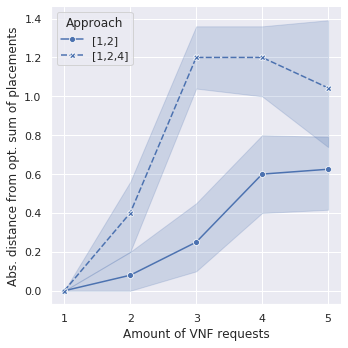

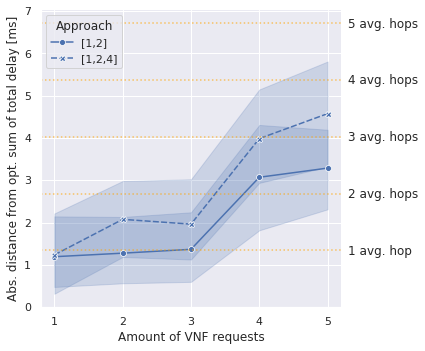

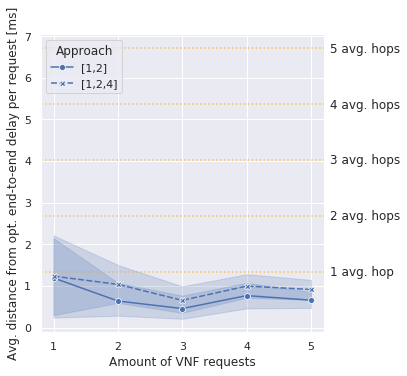

In [4]:
# WITHOUT INFEASIBLES!

## Distances from optimal solution

# placements (cuz its easy)
distances = pd.DataFrame(columns=["hierarchy", "gurobi_seed", "vnf_requests_id","requests_count", "placements_distance", "total_delay_distance", "e2e_delay_distance", "sum_e2e_delay_distance"])

needed_runs = set()

for (i, gurobi_seed, hierarchy_id, hierarchy, hierarchy_paths, graph_path, vnf_requests_id, ingr_egr, requests_count, vnf_requests_path, placements, runtime, avg_total_delay,avg_e2e_delay,sum_total_delay,sum_e2e_delay, method) in df_wo_inf.itertuples():
    # now placement distance ->
    if hierarchy == '[1]':
        # no loss for baseline
        continue
    
    opt = df_bsline_wo_inf[(df_bsline_wo_inf.gurobi_seed == gurobi_seed) & (df_bsline_wo_inf.vnf_requests_id == vnf_requests_id)]
    next_gurobi_seed = int(gurobi_seed)
    ctr = 0
    # if the run failed for the baseline check if there is another seed (they are all the same)
    while len(opt) == 0 and ctr < 5:
        next_gurobi_seed = int(next_gurobi_seed) + 1 % 5
        opt = df_bsline_wo_inf[(df_bsline_wo_inf.gurobi_seed == gurobi_seed) & (df_bsline_wo_inf.vnf_requests_id == vnf_requests_id)]
        ctr += 1
    if len(opt) == 0:
        continue
    if placements == 'INFEASIBLE':
        distance = float(opt['placements'])
    else:
        distance = float(abs(float(placements)-float(opt['placements'])))
    # delay distances
    if distance == 0:
        tot_delay_distance = abs(sum_total_delay - opt['sum_total_delay'])
        avg_e2e_delay_distance = abs(avg_e2e_delay - opt['avg_e2e_delay'] )
        sum_e2e_delay_distance = abs(sum_e2e_delay - opt['sum_e2e_delay'])
        
        distances = distances.append({'hierarchy': hierarchy, 'gurobi_seed':gurobi_seed, 'vnf_requests_id':vnf_requests_id, 'placements_distance':distance,
                                      'total_delay_distance':float(tot_delay_distance), 'requests_count':requests_count, 'e2e_delay_distance':float(avg_e2e_delay_distance),
                                     'sum_e2e_delay_distance': float(sum_e2e_delay_distance)}, ignore_index=True)
    else:
        if placements == 'INFEASIBLE':
            tot_delay_distance = float(opt['sum_total_delay'])
            avg_e2e_delay_distance=float(opt['avg_e2e_delay'])
        else:
            bs_fillup = baseline_fillup.query("vnf_requests_id == {} & placements == {}".format(vnf_requests_id, placements))
            tot_delay_opt = bs_fillup['sum_total_delay']
            tot_delay_distance = abs(float(sum_total_delay) - float(tot_delay_opt))
            avg_e2e_delay_opt = bs_fillup['avg_e2e_delay']
            avg_e2e_delay_distance = abs(float(avg_e2e_delay) - float(avg_e2e_delay_opt))
            sum_e2e_delay_opt = bs_fillup['sum_e2e_delay']
            sum_e2e_delay_distance = abs(float(sum_e2e_delay) - float(sum_e2e_delay_opt))
            
        distances = distances.append({'hierarchy': hierarchy, 'gurobi_seed':gurobi_seed, 'vnf_requests_id':vnf_requests_id, 'placements_distance':distance,
                                      'total_delay_distance':tot_delay_distance, 'requests_count':requests_count, 'e2e_delay_distance':float(avg_e2e_delay_distance),
                                     'sum_e2e_delay_distance': float(sum_e2e_delay_distance)}, ignore_index=True)

        
# plot the placements distances
sns_plot = sns.relplot(data=distances, x="requests_count", markers=True, y="placements_distance", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Abs. distance from opt. sum of placements')
plt.legend(title='Approach', loc='upper left', labels=['[1,2]', '[1,2,4]'])
sns_plot.savefig("final_figs/final_absolute_placements_wo_inf.pdf")

# total delay distance
sns_plot = sns.relplot(data=distances, x="requests_count",markers=True, y="total_delay_distance", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Abs. distance from opt. sum of total delay [ms]')
plt.legend(title='Approach', loc='upper left', labels=['[1,2]', '[1,2,4]'])

plt.xticks(np.arange(1,6,1))
ax1= sns_plot.axes[0][0]

avg_delay = 1.342150105084392
ax1.axhline(avg_delay, ls=':', color='orange', alpha=0.6)
ax1.text(5.3, avg_delay - .1, "1 avg. hop")
ax1.text(5.3, 2 * avg_delay - .1, "2 avg. hops")
ax1.text(5.3, 3* avg_delay - .1, "3 avg. hops")
ax1.text(5.3, 4*avg_delay -.1, "4 avg. hops")
ax1.text(5.3, 5*avg_delay-.1, "5 avg. hops")
ax1.axhline(2 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(3 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(4 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(5 * avg_delay, ls=':', color='orange', alpha=0.6)
sns_plot.savefig("final_figs/final_absolute_distance_tot_wo_inf.pdf")


# avg e2e delay distance
sns_plot = sns.relplot(data=distances, x="requests_count",markers=True, y="e2e_delay_distance", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Avg. distance from opt. end-to-end delay per request [ms]')
plt.legend(title='Approach', loc='upper left', labels=['[1,2]', '[1,2,4]'])

plt.xticks(np.arange(1,6,1))
ax1= sns_plot.axes[0][0]

avg_delay = 1.342150105084392
ax1.axhline(avg_delay, ls=':', color='orange', alpha=0.6)
ax1.text(5.3, avg_delay - .1, "1 avg. hop")
ax1.text(5.3, 2 * avg_delay - .1, "2 avg. hops")
ax1.text(5.3, 3* avg_delay - .1, "3 avg. hops")
ax1.text(5.3, 4*avg_delay -.1, "4 avg. hops")
ax1.text(5.3, 5*avg_delay-.1, "5 avg. hops")
ax1.axhline(2 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(3 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(4 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(5 * avg_delay, ls=':', color='orange', alpha=0.6)
sns_plot.savefig("final_figs/final_e2e.pdf")

print("Need the following runs: {}".format(needed_runs))
